# Fine tuning using Llama 2 13b

### Base Model and Quantization

In [3]:
# GPU 0: NVIDIA GeForce RTX 4090
# GPU 1: NVIDIA GeForce RTX 4090
# GPU 2: NVIDIA GeForce RTX 4090
# GPU 3: NVIDIA GeForce RTX 3090 Ti
# GPU 4: NVIDIA GeForce RTX 3090 Ti
# GPU 5: NVIDIA GeForce RTX 3090
# GPU 6: NVIDIA GeForce RTX 3090
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # ""makes all visible, "0" GPU 0 visible

### Supress warnings

In [4]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

### Inspect the base model

In [5]:
access_token = os.getenv("HF_TOKEN")

In [6]:
from huggingface_hub import login
login(access_token)

In [7]:
import os
import torch

from transformers import AutoModelForSequenceClassification, BitsAndBytesConfig

model_name = "Llama-2-13b-hf"
checkpoint = "meta-llama/"+model_name

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, quantization_config=bnb_config, device_map="auto", num_labels=2, token=access_token)

In [6]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
LlamaForSequenceClassification                          --
├─LlamaModel: 1-1                                       --
│    └─Embedding: 2-1                                   163,840,000
│    └─ModuleList: 2-2                                  --
│    │    └─LlamaDecoderLayer: 3-1                      158,607,360
│    │    └─LlamaDecoderLayer: 3-2                      158,607,360
│    │    └─LlamaDecoderLayer: 3-3                      158,607,360
│    │    └─LlamaDecoderLayer: 3-4                      158,607,360
│    │    └─LlamaDecoderLayer: 3-5                      158,607,360
│    │    └─LlamaDecoderLayer: 3-6                      158,607,360
│    │    └─LlamaDecoderLayer: 3-7                      158,607,360
│    │    └─LlamaDecoderLayer: 3-8                      158,607,360
│    │    └─LlamaDecoderLayer: 3-9                      158,607,360
│    │    └─LlamaDecoderLayer: 3-10                     158,607,360
│    │    └

In [7]:
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
 

### Load the news dataset from pickle file
If any of the check_files don't exist then load the pickle file

In [9]:
import pickle

base_path = './data/'
os.makedirs(base_path, exist_ok=True)

file_name = 'news_small_dataset.pkl'
file_path = base_path+file_name

def pickle_dataset(dataset, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(dataset, file)
        print(f"Dataset has been pickled to: {file_path}")

def load_pickle_dataset(file_path):
    with open(file_path, 'rb') as file:
        dataset = pickle.load(file)
        print(f"Dataset has been loaded from: {file_path}")
    return dataset

def check_files_exists(file_names):
    for name in file_names:
        file_path = os.path.join(base_path, name)
        if os.path.exists(file_path):
            return True
    return False

# if these files exist we do not want to load the news_dataset.pkl to tokenize and make these files
check_files = [model_name+'-small_tokenized_train_ds.pkl', model_name+'-small_tokenized_eval_ds.pkl', model_name+'-small_tokenized_test_ds.pkl']

if check_files_exists(check_files):
    print("At least one of the specified files already exists. Not loading new dataset.")
else:
    news_split_ds = load_pickle_dataset(file_path)
    print(news_split_ds)
    total_rows = (news_split_ds['train'].num_rows +
              news_split_ds['eval'].num_rows +
              news_split_ds['test'].num_rows)
    print("Total number of rows:", total_rows)
    print("Dataset loaded successfully.")

At least one of the specified files already exists. Not loading new dataset.


### Tokenization of data

<p>
return_tensors="pt": This argument configures the tokenizer to output PyTorch ("pt") tensors. If you're working with TensorFlow, you'd use "tf" instead, and for NumPy arrays, you could omit this argument or set return_tensors to None.
</p>
<p>
Direct Model Input: By converting the tokenized input into tensors, the output can be directly used as input to a PyTorch model, fitting seamlessly into the data processing pipeline for model training or inference.

Handling of Batch Inputs: This approach also supports batch inputs. If you pass a list of texts to the tokenizer with return_tensors="pt", it will automatically pad the sequences to the maximum length in the batch, returning a tensor where the first dimension is the batch size.

Padding and Truncation: The padding=True and truncation=True arguments ensure that all sequences are padded to the same length (up to max_length) and are truncated if they exceed this length, which is important for processing sequences in batches.

</p>

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint, token=access_token)

tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)

def tokenize_fn(news):
    return tokenizer(news['article'], padding=True, truncation=True, max_length=512, return_tensors="pt")

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

NameError: name 'model' is not defined

### Tokenize train, evaluation, and test datasets
If any of the check files exist then don't run tokenization and save some time.
Else load the pickle files that already exist.

In [11]:
if not check_files_exists(check_files):
    tokenized_train_ds = news_split_ds['train'].map(tokenize_fn, batched=True)
    tokenized_eval_ds = news_split_ds['eval'].map(tokenize_fn, batched=True)
    tokenized_test_ds = news_split_ds['test'].map(tokenize_fn, batched=True)

    print(tokenized_train_ds.features)
    print(tokenized_eval_ds.features)
    print(tokenized_test_ds.features)
    
    pickle_dataset(tokenized_train_ds, base_path+model_name+'-small_tokenized_train_ds.pkl')
    pickle_dataset(tokenized_eval_ds, base_path+model_name+'-small_tokenized_eval_ds.pkl')
    pickle_dataset(tokenized_test_ds, base_path+model_name+'-small_tokenized_test_ds.pkl')
else:
    print("Files already exist, so load datasets")
    tokenized_train_ds = load_pickle_dataset(base_path+model_name+'-small_tokenized_train_ds.pkl')
    tokenized_eval_ds = load_pickle_dataset(base_path+model_name+'-small_tokenized_eval_ds.pkl')
    tokenized_test_ds = load_pickle_dataset(base_path+model_name+'-small_tokenized_test_ds.pkl')

Files already exist, so load datasets
Dataset has been loaded from: ./data/Llama-2-13b-hf-small_tokenized_train_ds.pkl
Dataset has been loaded from: ./data/Llama-2-13b-hf-small_tokenized_eval_ds.pkl
Dataset has been loaded from: ./data/Llama-2-13b-hf-small_tokenized_test_ds.pkl


### Look at the tokenized data
Notice what the actual data looks like, and then the tokenized data which is a bunch of numbers, and then the attention mask at the end.

In [11]:
count_train_records = len(tokenized_train_ds)
count_eval_records = len(tokenized_eval_ds)
count_test_records = len(tokenized_test_ds)
print(f"Number of records in training dataset: {count_train_records}")
print(f"Number of records in evaluation dataset: {count_eval_records}")
print(f"Number of records in test dataset: {count_test_records}")
count_total_records = count_train_records + count_eval_records + count_test_records
print(f"Total number of records: {count_total_records}")

Number of records in training dataset: 33611
Number of records in evaluation dataset: 7203
Number of records in test dataset: 7203
Total number of records: 48017


In [12]:
first_record = tokenized_train_ds[0]
print(first_record)

{'article': "In a year where homicides, rapes and robberies increased slightly, New York City still saw serious crime drop 1.7 percent in 2015, continuing an overall decline that began in the 1990s, NYPD Commissioner William Bratton said Monday.\nAt a news conference with Mayor Bill de Blasio, Bratton touted last year’s crime statistics, which he said, when combined with an even larger decline in 2014, put to rest the fear that substantial decreases couldn’t continue under the new administration at City Hall.\n“While we have had some fluctuation, some increases in certain categories, the overall trend in all our crime categories continues to go down,” Bratton told reporters. “It was a very good year for us, 2015.\nHomicides increased by 4.5 percent in 2015, rising to 350 from 333 in the prior year, which was the lowest since 1994, said Deputy Commissioner Dermot Shea. Rapes increased 6 percent and robberies rose 2 percent, said Shea, who is in charge of data collection and operations f

### Turn on accelerate

In [12]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

### LoRA - Low-Rank Adaptation

In [14]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model, TaskType

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,
    task_type=TaskType.SEQ_CLS,
)

model = get_peft_model(model, config)
model = accelerator.prepare_model(model)

### Inspect the model

In [15]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}")

In [16]:
print_trainable_parameters(model)
model

trainable params: 31303680 || all params: 6539453440 || trainable%: 0.4786895462627531


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 5120)
        (layers): ModuleList(
          (0-39): 40 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=5120, out_features=5120, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=5120, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=5120, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
           

### Look at hardware

In [17]:
print(f"Available GPUs: {torch.cuda.device_count()}")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

Available GPUs: 1
GPU 0: NVIDIA GeForce RTX 4090


In [18]:
!nvidia-smi

Thu May 23 04:07:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0 Off |                  N/A |
| 82%   83C    P2            407W /  420W |    2430MiB /  24576MiB |    100%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
if torch.cuda.device_count() > 1:
    model.is_parallelizable = True
    model.model_parallel = True

In [14]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return {'accuracy': acc, 'f1': f1}

In [15]:
project_name = "praxis-"+model_name+"-small-finetune"
output_dir_path = "./" + project_name
output_dir_path

'./praxis-Llama-2-13b-hf-small-finetune'

In [22]:
import torch
torch.cuda.empty_cache()

### Training

In [23]:
import transformers
from pathlib import Path

transformers.set_seed(777)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_eval_ds,
    args=transformers.TrainingArguments(
        output_dir=output_dir_path,
        num_train_epochs=10,
        logging_steps=10,
        logging_dir=output_dir_path+"/logs",
        evaluation_strategy='epoch',
        save_strategy='epoch',
        bf16=True,
        optim="paged_adamw_8bit",
        do_eval=True,
    ),
    compute_metrics=compute_metrics,
    data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer),
)

model.config.use_cache = False
trainer.train(resume_from_checkpoint=False)  # Turn to True if power goes out...

2024-05-23 04:07:32.804881: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 04:07:33.532729: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
wandb: Currently logged in as: nispoe. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.031500,0.013660,0.996529,0.996331
2,0.000000,0.024692,0.997362,0.997214
3,0.000600,0.029725,0.997223,0.997065
4,0.000200,0.023089,0.997362,0.997213
5,0.000000,0.022280,0.997779,0.997655
6,0.000000,0.025119,0.997362,0.997212
7,0.000000,0.028333,0.997501,0.997360
8,0.000000,0.031121,0.997362,0.997214
9,0.000000,0.034246,0.997362,0.997212
10,0.000000,0.034216,0.997362,0.997212


TrainOutput(global_step=42020, training_loss=0.008493819665418994, metrics={'train_runtime': 207590.7742, 'train_samples_per_second': 1.619, 'train_steps_per_second': 0.202, 'total_flos': 1.313326250018734e+19, 'train_loss': 0.008493819665418994, 'epoch': 10.0})

### Determine best checkpoint

In [23]:
!ls -ltr {output_dir_path}

total 44
drwxr-xr-x 2 nispoe nispoe 4096 May 25 16:08 logs
drwxrwxr-x 2 nispoe nispoe 4096 May 25 16:08 checkpoint-4202
drwxrwxr-x 2 nispoe nispoe 4096 May 25 16:08 checkpoint-8404
drwxrwxr-x 2 nispoe nispoe 4096 May 25 16:08 checkpoint-12606
drwxrwxr-x 2 nispoe nispoe 4096 May 25 16:08 checkpoint-16808
drwxrwxr-x 2 nispoe nispoe 4096 May 25 16:08 checkpoint-21010
drwxrwxr-x 2 nispoe nispoe 4096 May 25 16:08 checkpoint-25212
drwxrwxr-x 2 nispoe nispoe 4096 May 25 16:08 checkpoint-29414
drwxrwxr-x 2 nispoe nispoe 4096 May 25 16:08 checkpoint-33616
drwxrwxr-x 2 nispoe nispoe 4096 May 25 16:08 checkpoint-37818
drwxrwxr-x 2 nispoe nispoe 4096 May 25 16:08 checkpoint-42020


In [17]:
from tensorflow.python.summary.summary_iterator import summary_iterator
import glob
import os

logs_directory = os.path.join('./', project_name, 'logs')
file_pattern = 'events.out.tfevents.*'

event_files = glob.glob(os.path.join(logs_directory, file_pattern))

def print_events_from_file(event_files):
    for event_file in event_files:
        print(f"Reading events from file: {event_file}")
        try:
            for e in summary_iterator(event_file):
                for v in e.summary.value:
                    if v.HasField('simple_value'):
                        print(f"Step: {e.step}, {v.tag}: {v.simple_value}")
        except Exception as e:  # Just in case the event file is not readable
            print(f"Failed to read {event_file}: {e}")

print_events_from_file(event_files)

Reading events from file: ./praxis-Llama-2-13b-hf-small-finetune/logs/events.out.tfevents.1716455254.hephaestus.15333.0
Step: 10, train/loss: 1.0683000087738037
Step: 10, train/grad_norm: 19.843873977661133
Step: 10, train/learning_rate: 4.998810254619457e-05
Step: 10, train/epoch: 0.0023798190522938967
Step: 20, train/loss: 0.8248000144958496
Step: 20, train/grad_norm: 19.309377670288086
Step: 20, train/learning_rate: 4.997620271751657e-05
Step: 20, train/epoch: 0.004759638104587793
Step: 30, train/loss: 0.6651999950408936
Step: 30, train/grad_norm: 13.729391098022461
Step: 30, train/learning_rate: 4.9964302888838574e-05
Step: 30, train/epoch: 0.007139457389712334
Step: 40, train/loss: 0.6898999810218811
Step: 40, train/grad_norm: 27.610836029052734
Step: 40, train/learning_rate: 4.995240306016058e-05
Step: 40, train/epoch: 0.009519276209175587
Step: 50, train/loss: 0.26980000734329224
Step: 50, train/grad_norm: 5.266439437866211
Step: 50, train/learning_rate: 4.994050323148258e-05
St

In [20]:
import pandas as pd
from tensorflow.python.summary.summary_iterator import summary_iterator

logs_directory = os.path.join('./', project_name, 'logs')
file_pattern = 'events.out.tfevents.*'

event_files = glob.glob(os.path.join(logs_directory, file_pattern))

def extract_metrics(event_files):
    data = []
    last_train_loss = None

    for event_file in event_files:
        for e in summary_iterator(event_file):
            for v in e.summary.value:
                if v.HasField('simple_value'):
                    step = e.step
                    metric_name = v.tag.split('/')[-1]
                    metric_value = v.simple_value

                    formatted_value = f"{metric_value:.6f}"

                    if 'train/loss' in v.tag:
                        last_train_loss = formatted_value

                    if 'eval' in v.tag:
                        entry = next((item for item in data if item['Step'] == step), None)
                        if not entry:
                            entry = {'Step': step, 'Train Loss': last_train_loss, 'Eval Loss': None, 'Accuracy': None, 'F1': None}
                            data.append(entry)
                        if 'loss' in v.tag:
                            entry['Eval Loss'] = formatted_value
                        elif 'accuracy' in v.tag:
                            entry['Accuracy'] = formatted_value
                        elif 'f1' in v.tag:
                            entry['F1'] = formatted_value

    return data

metrics_data = extract_metrics(event_files)

df = pd.DataFrame(metrics_data)
df = df.sort_values(by='Step')

file_path = "./images/"+model_name+"_Checkpoint_Data.csv"
df.to_csv(file_path, index=False)

print(df)

DataLossError: truncated record at 3998' failed with Read less bytes than requested

In [26]:
df.fillna({
    'Eval Loss': float('inf'),
    'Accuracy': 0,
    'F1': 0
}, inplace=True)

df['Eval Loss'] = df['Eval Loss'].astype(float)
df['Accuracy'] = df['Accuracy'].astype(float)
df['F1'] = df['F1'].astype(float)

df['Eval Loss Rank'] = df['Eval Loss'].rank(method='min', ascending=True)
df['Accuracy Rank'] = df['Accuracy'].rank(method='min', ascending=False)
df['F1 Rank'] = df['F1'].rank(method='min', ascending=False)

df['Rank Sum'] = df['Eval Loss Rank'] + df['Accuracy Rank'] + df['F1 Rank']

best_checkpoint = df.loc[df['Rank Sum'].idxmin()]

checkpoint_folder_name = f"checkpoint-{best_checkpoint['Step']}"
print(f"Best Checkpoint Step: {checkpoint_folder_name}")
print(best_checkpoint[['Step', 'Train Loss', 'Eval Loss', 'Accuracy', 'F1', 'Rank Sum']])

NameError: name 'df' is not defined

### Run TensorBoard
tensorboard --logdir=~/kuk/Praxis/praxis-Llama-2-7b-hf-small-finetune/logs --host=0.0.0.0

### PAUSE SCRIPT

In [ ]:
# My flag to pause the script, set to True to pause
pause_script = False

In [ ]:
class StopExecution(Exception):
    def _render_traceback_(self):
        print("Script Paused")
        pass

In [ ]:
if pause_script:
    raise StopExecution

### Testing

In [14]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    quantization_config=bnb_config,
    device_map="auto",
    num_labels=2,
    token=access_token,
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    checkpoint,
    token=access_token,
    trust_remote_code=True,
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-2-13b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from peft import PeftModel
# test_checkpoint_name = checkpoint_folder_name
test_checkpoint_name = "checkpoint-8404"
ft_model = PeftModel.from_pretrained(base_model, project_name+'/'+test_checkpoint_name)

In [16]:
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    ft_model = torch.nn.DataParallel(ft_model)

ft_model.cuda()

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 5120)
        (layers): ModuleList(
          (0-39): 40 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=5120, out_features=5120, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=5120, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=5120, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
           

In [17]:
from tqdm.auto import tqdm

processed_predictions = []

with torch.no_grad():
    for record in tqdm(tokenized_test_ds):

        eval_prompt = record['article']
        model_input = tokenize_fn({'article': eval_prompt})

        # model_input = {k: v.to('cuda') for k, v in model_input.items()}
        
        outputs = ft_model(**model_input)
        logits = outputs.logits
        
        prediction = logits[0].argmax(-1).item()  # Use .item() to get a Python number
        processed_predictions.append(prediction)

  0%|          | 0/7203 [00:00<?, ?it/s]

2024-05-25 16:19:08.423688: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 16:19:09.029872: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Accuracy and F1

In [18]:
true_articles = tokenized_test_ds['label']

In [19]:
from sklearn.metrics import f1_score, accuracy_score

accuracy = accuracy_score(true_articles, processed_predictions)
print("accuracy:", accuracy)

accuracy: 0.9970845481049563


In [20]:
print(true_articles)

[0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 

In [21]:
print(processed_predictions)

[0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 

In [22]:
f1_score = f1_score(true_articles, processed_predictions, average='macro')
print("f1_score:", f1_score)

f1_score: 0.9969239165180597


### Confusion Matrix

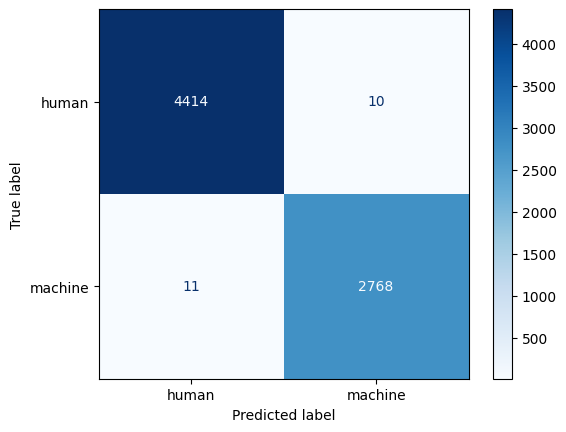

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(tokenized_test_ds['label'], processed_predictions)

labels = ['human', 'machine']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [30]:
file_name = f"{project_name}.ipynb"
html_file_name = f"{file_name.replace('.ipynb', '.html')}"

command = f"jupyter nbconvert '{file_name}' --to html --output-dir './html' --output '{html_file_name}'"
get_ipython().system(command)

[NbConvertApp] Converting notebook praxis-Llama-2-13b-hf-small-finetune-v11.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 1280647 bytes to html/praxis-Llama-2-13b-hf-small-finetune-v11.html
